# spinal_test7.ipynb

This is a version of `spinal_test6` with the addition of a short reflex loop using input correlation.

In [1]:
%cd ../..
from draculab import *
import numpy as np
import matplotlib.pyplot as plt
import time

/home/z/projects/draculab


In [2]:
##################################
####### Create the network #######
##################################

# First the network object, the plant, the list of coordinates
net_params = {'min_delay' : 0.005,
              'min_buff_size' : 10 }
P_params = {'type' : plant_models.bouncy_planar_arm,
            'mass1' : .5,
            'mass2' : .5,
            'smin' : -0.4,
            'p1' : (-0.01, 0.04),
            'p3' : (0., 0.05),
            'p5' : (0.01, -0.05),
            'init_q1' : np.pi/4., #0.53496133, 
            'init_q2' : np.pi/2., #0.89566479, 
            'init_q1p' : 0.,
            'init_q2p' : 0.,
            'g' : 0.,
            'mu1' : .5,
            'mu2' : .5,
            'l_torque' : 0.01,
            'l_visco' : 0.05,
            'm_gain' : 30.,
            'l_gain' : 1.,
            'v_gain' : 5.,
            'spring' : 1.,
            'tau' : 0.1 } # ficticious time constant used in create_freqs_steps
net = network(net_params)
P = net.create(1, P_params)
arm = net.plants[P]

# We organize the spinal connections through 4 types of symmetric relations
# these lists are used to set intraspinal connections and test connection matrices
antagonists = [(0,3), (1,2), (4,5)]
part_antag = [(0,2),(0,5), (3,4), (1,3)]
synergists = [(0,1), (0,4), (2,3), (3,5)]
part_syne = [(1,4), (2,5)]
self_conn = [(x,x) for x in range(6)]

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# UNIT PARAMETER DICTIONARIES
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
par_heter = 0.001 # range of heterogeneity as a fraction of the original value
randz1 = lambda : (1. + par_heter*(np.random.rand()-0.5))
randz6 = lambda : (1. + par_heter*(np.random.rand(6)-0.5))
randz12 = lambda : (1. + par_heter*(np.random.rand(12)-0.5))
randz18 = lambda : (1. + par_heter*(np.random.rand(18)-0.5))

SF_params = {'type' : unit_types.sigmoidal,
             'thresh' : 1.3 * randz6(),
             'slope' : 2.5 * randz6(),
             'init_val' : 0.2 * randz6(),
             'tau' : 0.03 * randz6() } 
SP_params = {'type' : unit_types.source,
             'init_val' : 0.5,
             'tau_fast' : 0.02,
             'tau_mid' : 0.1,
             'function' : lambda t: None }
SP_CHG_params = {'type' : unit_types.sigmoidal,
              'thresh' : 0.3,
              'slope' : 9.,
              'init_val' : 0.1,
              'tau' : 0.01 }
SPF_params = {'type' : unit_types.sigmoidal,
              'thresh' : 0.4 * randz6(),
              'slope' : 6. * randz6(),
              'init_val' : 0.3 * randz6(),
              'tau_fast': 0.005,
              'tau_mid': 0.05,
              'tau_slow' : 5.,
              'tau' : 0.02 * randz6() }
M_params = {'type' : unit_types.gated_out_norm_am_sig,
            'thresh' : 0. * randz6(),
            'slope' : 3. * randz6(),
            'init_val' : 0.2 * randz6(),
            'delay' : 0.2,
            'tau_fast': 0.01,
            'tau_mid': 0.05,
            'tau_slow' : 2.,
            'tau' : 0.01 * randz6(),
            'des_out_w_abs_sum' : 1. }
CE_params = {'type' : unit_types.gated_rga_inpsel_adapt_sig,
             'thresh' : 0.2 * randz6(),
             'slope' : 2. * randz6(),
             'init_val' : 0.2 * randz6(),
             'tau' : 0.02 * randz6(),
             'tau_fast': 0.01,
             'tau_mid' : 0.05,
             'tau_slow' : 6.,
             'custom_inp_del' : 15,
             'integ_amp' : 0.5,
             'adapt_amp' : 8.,
             'delay' : 0.2,
             'des_out_w_abs_sum' : 1. }
CI_params = {'type' : unit_types.gated_rga_inpsel_adapt_sig,
             'thresh' : 0.5 * randz6(),
             'slope' : 2. * randz6(),
             'init_val' : 0.2 * randz6(),
             'tau' : 0.5 * randz6(), #0.02 * randz6(),
             'tau_fast': 0.01,
             'tau_mid' : 0.05,
             'tau_slow' : 6.,
             'custom_inp_del' : 15,
             'integ_amp' : 0.5,
             'adapt_amp' : 8.,
             'delay' : 0.2,
             'des_out_w_abs_sum' : 1. }
AL_params = {'type' : unit_types.sigmoidal,
             'thresh' : 0.3 * randz6(),
             'slope' : 2. * randz6(),
             'init_val' : 0.1 * randz6(),
             'tau' : 0.02 * randz6() }
AF_params = {'type' : unit_types.logarithmic,
             'init_val' : 0.5 * randz18(),
             'tau' : 0.02 * randz18(),
             'tau_fast': 0.005,
             'delay' : 0.1,
             'thresh' : [-.9, -0.5, 0.5,
                         -1.1, -0.5, 0.5,
                         -.8, -0.5, 0.5,
                         -.8, -0.5, 0.5,
                         -.8, -0.5, 0.5,
                         -1.4, -0.5, 0.5] } # length afferents report (l-l0)/l0
ACT_params = {'type' : unit_types.act,
              'tau_u' : 7.,
              'gamma' : 2.,
              'g' : 3.,
              'theta' : 1.4,
              'tau_slow' : 5.,
              'y_min' : 0.4,
              'rst_thr' : 0.3,
              'init_val' : 0. }
spf_sum_min = .4 # value where no corrections are needed anymore
y_min = 1./(1. + np.exp(-ACT_params['g']*(spf_sum_min - ACT_params['theta'])))
ACT_params['y_min'] = y_min

track_params = {'type' : unit_types.source,
                'init_val' : 0.02,
                'function' : lambda t: None }

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# CONNECTION DICTIONARIES
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# SF, SP to SPF
SFe__SPF_conn = {'rule' : "one_to_one",
                 'delay' : 0.01 }
SFi__SPF_conn = {'rule' : "one_to_one",
                 'delay' : 0.02 }
SFe__SPF_syn = {'type' : synapse_types.static,
                'init_w' : 1. }
SFi__SPF_syn = {'type' : synapse_types.static,
                'init_w' : -1. }
SPe__SPF_conn = {'rule' : "one_to_one",
                 'delay' : 0.01 }
SPi__SPF_conn = {'rule' : "one_to_one",
                 'delay' : 0.02 }
SPe__SPF_syn = {'type' : synapse_types.static,
                'init_w' : 1. }
SPi__SPF_syn = {'type' : synapse_types.static,
               'init_w' : -1. }
# SP to SP_CHG
SP__SP_CHG_conn = {'rule' : 'all_to_all',
                    'delay' : 0.01}
SP__SP_CHG_syn = {'type' : synapse_types.chg,
                  'init_w' : 0.,
                  'lrate' : 20. }
# SP_CHG to CE, CI
SP_CHG__CE_conn = {'rule' : "all_to_all",
                  'delay' : 0.02 }
SP_CHG__CE_syn = {'type' : synapse_types.static,
                  'inp_ports' : 3,
                  'init_w' : 1. }
SP_CHG__CI_conn = {'rule' : "all_to_all",
                   'delay' : 0.02 }
SP_CHG__CI_syn = {'type' : synapse_types.static,
                  'inp_ports' : 3,
                  'init_w' : 1. }
# SP_CHG to ACT
SP_CHG__ACT_conn = {'rule' : "all_to_all",
                   'delay' : 0.02 }
SP_CHG__ACT_syn = {'type' : synapse_types.static,
                  'inp_ports' : 1,
                  'init_w' : 1. }
# SP_CHG to M
SP_CHG__M_conn = {'rule' : "all_to_all",
                  'delay' : 0.02 }
SP_CHG__M_syn = {'type' : synapse_types.static,
                  'inp_ports' : 2,
                  'init_w' : 1. }
# SPF to M
SPF__M_conn = {'rule': 'one_to_one',
               'delay': 0.01 }
SPF__M_syn = {'type' : synapse_types.static, #synapse_types.inp_corr,
              'inp_ports' : 1,
              'lrate' : 0.,
              'input_type' : 'error', # if using inp_corr
              'init_w' : 2. }
# SPF to ACT
SPF__ACT_conn = {'rule' : "all_to_all",
                 'delay' : 0.02 }
SPF__ACT_syn = {'type' : synapse_types.static,
                'inp_ports' : 0,
                'init_w' : 1. }
# ACT to CE,CI
ACT__CE_conn = {'rule' : "all_to_all",
                'delay' : 0.02 } 
ACT__CE_syn = {'type' : synapse_types.static,
               'inp_ports' : 4,
               'init_w' : 1. }
ACT__CI_conn = {'rule' : "all_to_all",
                'delay' : 0.02 } 
ACT__CI_syn = {'type' : synapse_types.static,
               'inp_ports' : 4,
               'init_w' : 1. }
# motor to spinal connections
# creating a test matrix
M_CE = np.zeros((6, 6))
M_CI = np.zeros((6, 6))
for x in range(6):
    M_CI[x,x] = 1.
    for pair in antagonists:
        if x == pair[0]:
            M_CE[x, pair[1]] = 1.
            M_CE[pair[1], x] = 1.
    for pair in part_antag:
        if x == pair[0]:
            M_CE[x, pair[1]] = 0.4
            M_CE[pair[1], x] = 0.4
    for pair in synergists:
        if x == pair[0]:
            M_CI[x, pair[1]] = 0.5
            M_CI[pair[1], x] = 0.5
    for pair in part_syne:
        if x == pair[0]:
            M_CI[x, pair[1]] = 0.3
            M_CI[pair[1], x] = 0.3
M_CE = 0.4*(np.random.random((6,6)) - 0.5) # random initial connections!!!!!!!!!!!!!!!!!!!
M_CI = 0.4*(np.random.random((6,6)) - 0.5) # random initial connections!!!!!!!!!!!!!!!!!!!
M__CE_conn = {'rule': 'all_to_all',
             'delay': 0.02 }
M__CE_syn = {'type' : synapse_types.gated_rga,
             'inp_ports' : 0,
             'lrate' : 50.,
             'w_sum' : 2.,
             'init_w' : M_CE.flatten() }
M__CI_conn = {'rule': 'all_to_all',
             'delay': 0.02 }
M__CI_syn = {'type' : synapse_types.gated_rga,
             'inp_ports' : 0,
             'lrate' : 50,
             'w_sum' : .5,
             'init_w' : M_CI.flatten() }
# interneurons to alpha motoneurons
CE__AL_conn = {'rule' : 'one_to_one',
               'delay' : 0.01 }
CE__AL_syn = {'type' : synapse_types.static,
              'init_w' : [1., 1., 1., 1., 1., 1.3] }
CI__AL_conn = {'rule' : 'one_to_one',
               'delay' : 0.01 }
CI__AL_syn = {'type' : synapse_types.static,
              'init_w' : -1. }
# alpha motoneurons to plant
AL__P_conn = {'inp_ports' : list(range(0,18,3)),
             'delays': 0.01 }
AL__P_syn = {'type': synapse_types.static,
            'init_w' : [1.3, 1.3, 1.7, 1.2, 1., 2.5] } #1.5 }
# length afferents to sensory
AF__SF_conn = {'rule' : 'one_to_one',
              'delay' : 0.02 }
AF__SF_syn = {'type' : synapse_types.static,
             'init_w' : [2.5, 2., 2.2, 2.5, 2.1, 2.1] }
# afferents to motor
## Creating a test matrix
AF_M = np.zeros((6, 18))
def a_m_connect(A_M, pair_list, weights):
    for pair in pair_list:
        A_M[pair[0], 3*pair[1]] = weights[0]
        A_M[pair[0], 3*pair[1]+1] = weights[1]
        A_M[pair[0], 3*pair[1]+2] = weights[2]
        A_M[pair[1], 3*pair[0]] = weights[0]
        A_M[pair[1], 3*pair[0]+1] = weights[1]
        A_M[pair[1], 3*pair[0]+2] = weights[2]        
a_m_connect(AF_M, self_conn, (0., -0.4, 0.4))
a_m_connect(AF_M, synergists, (0., -0.2, 0.2))
a_m_connect(AF_M, part_syne, (0., 0., 0.))
a_m_connect(AF_M, part_antag, (0., 0.2, -0.2))
a_m_connect(AF_M, antagonists, (0., 0.4, -0.4))
AF_M = AF_M.transpose()
AF_M = 0.2*(np.random.random((18,6)) - 0.5) # random initial connections!!!!!!!!!!!!!!!!!!!
f = 1. # going estimate the extra delay of error inputs wrt afferent inputs at M
w = 2.*np.pi*f
sf_del = np.arctan(np.mean(SF_params['tau'])*w)/w
spf_del = np.arctan(np.mean(SPF_params['tau'])*w)/w
delay = spf_del + sf_del + AF__SF_conn['delay'] + SFe__SPF_conn['delay']
steps = int(round(delay/net.min_delay))
AF_params['delay'] = AF_params['delay'] + net_params['min_delay'] * (np.ceil(delay/net_params['min_delay']) + 1)
AF__M_conn = {'rule' : 'all_to_all',
             'delay' : 0.02 }
AF__M_syn = {'type' : synapse_types.gated_inp_sel,
            'aff_port' : 0,
            'error_port' : 1,
            'w_sum' : 3.,
            'inp_ports' : 0, # afferent for out_norm_am_sig
            'input_type' : 'pred', # if using inp_corr
            'lrate' : 1.,
            'extra_steps' : steps,
            'init_w' : AF_M.flatten() } #.1 }
# afferents to spinal
AF__CE_conn = {'rule' : 'all_to_all',
               'delay' : 0.02 }
AF__CE_syn = {'type' : synapse_types.gated_inp_sel,
              'aff_port' : 2,
              'inp_ports' : 2,
              'error_port' : 0,
              'w_sum' : .3,
              'lrate' : 40.,
              'extra_steps' : 1,
              'init_w' : 0.05 }
AF__CI_conn = {'rule' : 'all_to_all',
               'delay' : 0.02 }
AF__CI_syn = {'type' : synapse_types.gated_inp_sel,
              'aff_port' : 2,
              'inp_ports' : 2,
              'error_port' : 0,
              'w_sum' : .3,
              'lrate' : 40.,
              'extra_steps' : 1,
              'init_w' : 0.05 }
# plant to afferents
bool_aff = [False] * 4 + [False, True, True, True] * 6
idx_aff = np.arange(28)[bool_aff] # indexes for afferent output in the arm
P__AF_conn = {'port_map' : [[(p,0)] for p in idx_aff],
             'delays' : 0.02 }
P__AF_syn = {'type' : synapse_types.static,
            'init_w' : [3.5, 3., .7]*6 }
# lateral connections in C
CE__CI_conn = {'rule' : 'one_to_one',
               'delay' : 0.01 }
CI__CE_conn = {'rule' : 'one_to_one',
               'delay' : 0.01 }
CE__CI_syn = {'type' : synapse_types.static,
              'inp_ports' : 1,
              'init_w' : .4 }
CI__CE_syn = {'type' : synapse_types.static, #corr_inh,
              'inp_ports' : 1,
              'lrate' : .0,
              'des_act' : 0.5,
              'init_w' : -1.5 }
C__C_conn = {'rule': 'one_to_one',
             'allow_autapses' : False,
             'delay' : 0.015 }
C__C_syn_antag = {'type' : synapse_types.bcm, #corr_inh,
                  'inp_ports': 1,
                  'init_w' : 1.,
                  'lrate' : 1.,
                  'des_act' : 0.5 }
C__C_syn_p_antag = {'type' : synapse_types.bcm,
                  'inp_ports': 1,
                  'init_w' : .4,
                  'lrate' : 1.,
                  'des_act' : 0.5 }
C__C_syn_syne = {'type' : synapse_types.static,
                 'inp_ports': 1,
                 'lrate' : 1.,
                 'init_w' : 1. }
C__C_syn_p_syne = {'type' : synapse_types.static,
                   'inp_ports': 1,
                   'lrate' : 1.,
                   'init_w' : 0.4 }

def approx_del(f):
    """ Returns an estimate fo the optimal delay for rga learning.
    
        We assume that the important loop for the learning rule in the C units
        is the one going through C-AL-P-AF-M-C.
        We also assume the delays to/from CI are the same as the ones for CE.
        
        Args:
            f : oscillation frequency of E-I pair in C, in Hertz
        Returns:
            2-tuple : (time_del, del_steps)
            time_del : A float with the time delay.
            del_steps : time delay as integer number of min_del steps.
    """
    w = 2.*np.pi*f
    al_del = np.arctan(np.mean(AL_params['tau'])*w)/w
    p_del = np.arctan(np.mean(P_params['tau'])*w)/w
    af_del = np.arctan(np.mean(AF_params['tau'])*w)/w
    m_del = np.arctan(np.mean(M_params['tau'])*w)/w
    D = [CE__AL_conn['delay'], AL__P_conn['delays'], np.mean(P__AF_conn['delays']),
         AF__M_conn['delay'], M__CE_conn['delay'] ]
    time_del = al_del + p_del + af_del + m_del + sum(D)
    del_steps = int(np.ceil(time_del/net_params['min_delay']))
    time_del = del_steps*net_params['min_delay']
    del_steps -= 1 # because this is an index, and indexes start at 0
    return time_del, del_steps

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# CREATING UNITS
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
SF = net.create(6, SF_params)
SP = net.create(6, SP_params)
SPF = net.create(6, SPF_params)
AL = net.create(6, AL_params)
AF = net.create(18, AF_params)
SP_CHG = net.create(1, SP_CHG_params)
# Approximating the delays for the rga rule
time_del, del_steps = approx_del(0.65) #0.65 is approximate CE/CI frequency observed in simulations
CE_params['delay'] = time_del
CI_params['delay'] = time_del
M_params['delay'] = time_del
CE_params['custom_inp_del'] = del_steps
CI_params['custom_inp_del'] = del_steps
CE = net.create(6, CE_params)
CI = net.create(6, CI_params)
M = net.create(6, M_params)
ACT = net.create(1, ACT_params)

# SET THE PATTERNS IN SP
t_pres = 50. # number of seconds to hold each set of target lengths
# list with hand coordinates [x,y] (meters)
hand_coords = [[0.3, 0.45], 
               [0.35, 0.4],
               [0.4, 0.35],
               [0.35, 0.3],
               [0.3, 0.25],
               [0.25, 0.3],
               [0.2, 0.35],
               [0.25, 0.4]]
               #[-0.1, 0.3],
               #[-0.1, 0.35]] # extra coordinate "for fun"
# list with muscle lengths corresponding to the hand coordinates
m_lengths = []
for coord in hand_coords:
    m_lengths.append(arm.coords_to_lengths(coord))
m_lengths = np.array(m_lengths)
# We need to translate these lengths to corresponding SF activity levels.
# For that it is necessary to recreate all their transformations
# The first transformation is from length to Ia activity in the muscle object
l = np.array([net.plants[P].muscles[i].l0 for i in range(6)]) # resting lengths
m_lengths = P_params['l_gain']*(m_lengths - l) / l
# Next transformation is through the logarithmic afferent units
l_arg = (P__AF_syn['init_w'][0]*m_lengths) - np.array(AF_params['thresh'][0:16:3])
l_affs = np.log(1. + np.maximum(0., l_arg))
# Next is from AF to SF
sf_arg = AF__SF_syn['init_w']*l_affs
sf_preds = 1./ (1. + np.exp(-np.mean(SF_params['slope'])*(sf_arg - np.mean(SF_params['thresh']))))

m_idxs = np.random.randint(len(hand_coords), size=1000) # index of target lengths
#m_idxs[0] = 0 # for testing

def make_fun(idx):
    """ create a function for the SP unit with index 'idx'. """
    return lambda t: sf_preds[m_idxs[int(np.floor(t/t_pres))]][idx]

for idx, u in enumerate(SP):
    net.units[u].set_function(make_fun(idx))

# tracking units
M_CE_track = net.create(len(M), track_params) # to track weights from M to CE
#M_CI_track = net.create(len(M), track_params) # to track weights from M to CI
AF_M0_track = net.create(18, track_params) # to track weights from AF to M0

xp_track = net.create(1, track_params) # del_avg_inp_deriv of C0 at port 1
up_track = net.create(1, track_params) # to track the derivative of CE0
sp_track = net.create(1, track_params) # avg_inp_deriv_mp for CE0 at port 0
spj_track = net.create(1, track_params) # input derivative for MX--CE0

ipx_track = net.create(12, track_params) # x coordinates of insertion points
ipy_track = net.create(12, track_params) # y coordinates of insertion points

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# CONNECTING
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# from M to CE
net.connect(M, CE, M__CE_conn, M__CE_syn)
# from M to CI
net.connect(M, CI, M__CI_conn, M__CI_syn)
# from CE to AL
net.connect(CE, AL, CE__AL_conn, CE__AL_syn)
# from CI to AL
net.connect(CI, AL, CI__AL_conn, CI__AL_syn)
# from AL to P
net.set_plant_inputs(AL, P, AL__P_conn, AL__P_syn)
# from P to AF
net.set_plant_outputs(P, AF, P__AF_conn, P__AF_syn)
# from AF to SF. Only the length afferents are selected
AF_len = [AF[i] for i in range(0,18,3)]
net.connect(AF_len, SF, AF__SF_conn, AF__SF_syn)
# from AF to M
net.connect(AF, M, AF__M_conn, AF__M_syn) # should be made before SPF-->M
# from AF to CE,CI
net.connect(AF, CE, AF__CE_conn, AF__CE_syn)
net.connect(AF, CI, AF__CI_conn, AF__CI_syn)
# from SF, SP to SPF
#net.connect(SF, SPF[0:6], SFe__SPF_conn, SFe__SPF_syn)
net.connect(SF, SPF, SFi__SPF_conn, SFi__SPF_syn) 
#net.connect(SP, SPF[0:6], SPi__SPF_conn, SPi__SPF_syn)
net.connect(SP, SPF, SPe__SPF_conn, SPe__SPF_syn)
# from SPF to M
net.connect(SPF, M, SPF__M_conn, SPF__M_syn) # should be after A-->M
# from SPF to ACT
net.connect(SPF, ACT, SPF__ACT_conn, SPF__ACT_syn)
# from CE to CI, and CI to CE
net.connect(CE, CI, CE__CI_conn, CE__CI_syn)
net.connect(CI, CE, CI__CE_conn, CI__CE_syn)
# from SP to SP_CHG
net.connect(SP, SP_CHG, SP__SP_CHG_conn, SP__SP_CHG_syn)
# from SP_CHG to CE,CI
net.connect(SP_CHG, CE, SP_CHG__CE_conn, SP_CHG__CE_syn)
net.connect(SP_CHG, CI, SP_CHG__CI_conn, SP_CHG__CI_syn)
# from SP_CHG to M
net.connect(SP_CHG, M, SP_CHG__M_conn, SP_CHG__M_syn)
# from SP_CHG to ACT
net.connect(SP_CHG, ACT, SP_CHG__ACT_conn, SP_CHG__ACT_syn)
# from ACT to CE, CI
net.connect(ACT, CE, ACT__CE_conn, ACT__CE_syn)
net.connect(ACT, CI, ACT__CI_conn, ACT__CI_syn)
# intraspinal connections 
EE_syn_dicts = [C__C_syn_syne, C__C_syn_p_syne]
EI_syn_dicts = [C__C_syn_antag, C__C_syn_p_antag]
EE_pair_lists = [synergists, part_syne] # order should match list above
EI_pair_lists = [antagonists, part_antag] # order should match list above
for pair_list, syn_dict in zip(EE_pair_lists, EE_syn_dicts):
    firsts = [CE[p[0]] for p in pair_list]
    seconds = [CE[p[1]] for p in pair_list]
    net.connect(firsts, seconds, C__C_conn, syn_dict)
    net.connect(seconds, firsts, C__C_conn, syn_dict)
for pair_list, syn_dict in zip(EI_pair_lists, EI_syn_dicts):
    firsts = [CE[p[0]] for p in pair_list] + [CE[p[1]] for p in pair_list]
    seconds = [CI[p[1]] for p in pair_list] + [CI[p[0]] for p in pair_list]
    net.connect(firsts, seconds, C__C_conn, syn_dict)

# SETTING UP WEIGHT TRACKING -- depends on the order of statements above!!!!!!
# This assumes the first connections to C are M-->C
def M_CE0_fun(idx):
    """ Creates a function to track a weight from M to CE0. """
    return lambda t: net.syns[CE[0]][idx].w
for idx in range(len(M)):
    net.units[M_CE_track[idx]].set_function(M_CE0_fun(idx))
# This assumes the first connections to M are AF-->M    
def AF_M0_fun(idx):
    """ Creates a function to track a weight from AF to M0. """
    return lambda t: net.syns[M[0]][idx].w
for idx in range(18):
    net.units[AF_M0_track[idx]].set_function(AF_M0_fun(idx))

# SETTING TRACKING OF PLASTICITY FACTORS FOR MX-->CE0
X = 0 # index of the M unit we'll monitor

net.units[xp_track[0]].set_function(lambda t: net.units[CE[0]].del_avg_inp_deriv_mp[1])
po_de = net.units[CE[0]].custom_inp_del
net.units[up_track[0]].set_function(lambda t: net.units[CE[0]].get_lpf_fast(po_de) - 
                                    net.units[CE[0]].get_lpf_mid(po_de))
net.units[sp_track[0]].set_function(lambda t: net.units[CE[0]].avg_inp_deriv_mp[0])
ds = net.syns[CE[0]][0].delay_steps
net.units[spj_track[0]].set_function(lambda t: net.units[M[X]].get_lpf_fast(ds) - 
                                     net.units[M[X]].get_lpf_mid(ds))
# TRACKING OF INSERTION POINTS (for the arm animation)
# make the source units track the tensions
def create_xtracker(arm_id, idx):
    return lambda t: net.plants[arm_id].ip[idx][0]
def create_ytracker(arm_id, idx):
    return lambda t: net.plants[arm_id].ip[idx][1]
for idx, uid in enumerate(ipx_track):
    net.units[uid].set_function(create_xtracker(P, idx))
for idx, uid in enumerate(ipy_track):
    net.units[uid].set_function(create_ytracker(P, idx))

In [7]:
# using light arm
start_time = time.time()
times, data, plant_data  = net.flat_run(55.)
#times, data, plant_data  = net.run(40.)
print('Execution time is %s seconds' % (time.time() - start_time))
data = np.array(data)
#Execution time is 8.687349319458008 seconds  << before sc_inp_sum_mp, flat_run(5.)

Execution time is 81.25984287261963 seconds


[0.06502099 0.14628604 0.06227075 0.09347732 0.03726609 0.18231461]
[0.0025422  0.12836629 0.00223035 0.16065961 0.07394092 0.12593419]


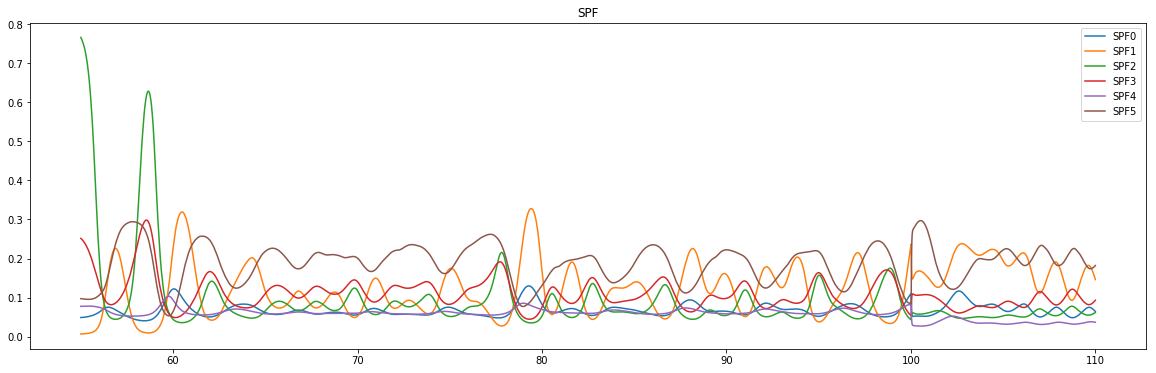

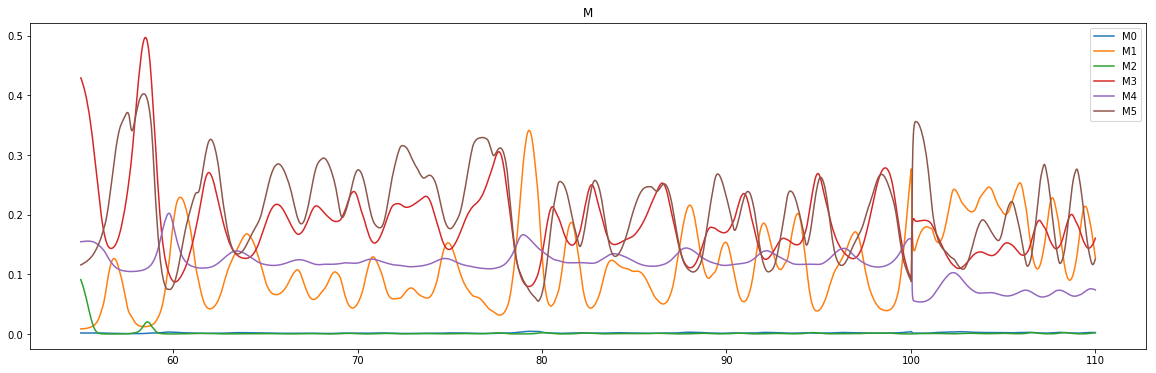

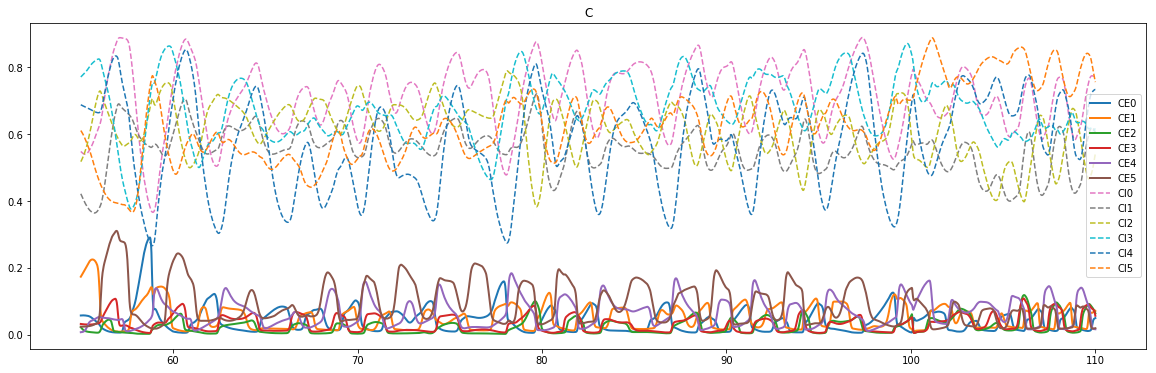

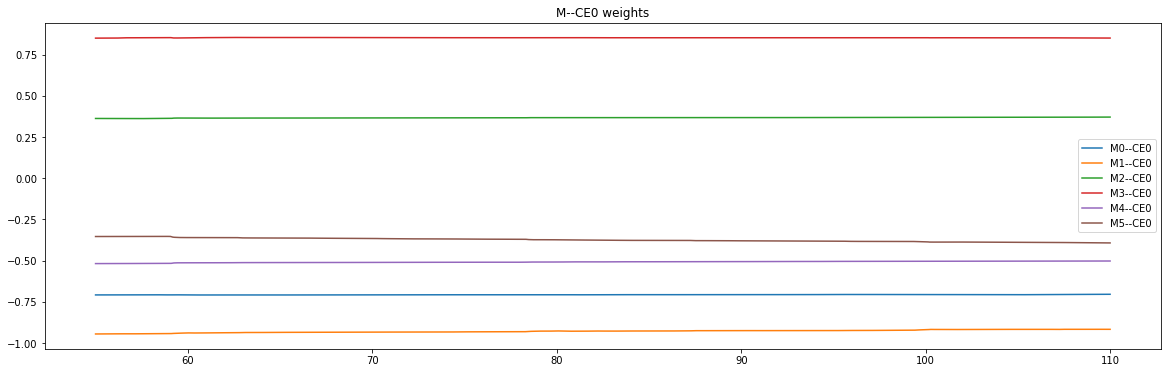

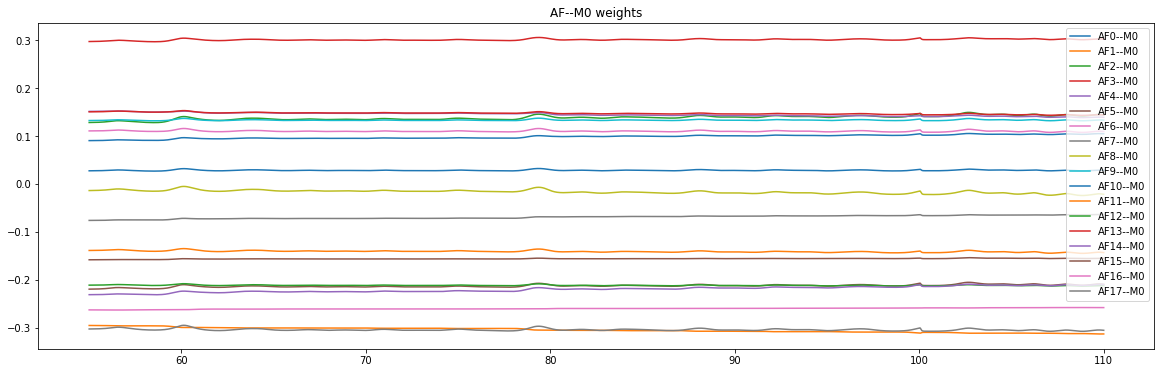

In [8]:
arm_activs = plant_data[P]
# SPF
fs = (20,6)
SPF_fig = plt.figure(figsize=fs)
SPF_data = np.array(data[SPF])
plt.plot(times, SPF_data.transpose())
SPF_legends = ['SPF'+str(i) for i in range(len(SPF))]
plt.legend(SPF_legends)
plt.title('SPF')
print(SPF_data[:,-1])

# M
M_fig = plt.figure(figsize=fs)
M_data = np.array(data[M])
plt.plot(times, M_data.transpose())
M_legends = ['M'+str(i) for i in range(len(M))]
plt.legend(M_legends)
plt.title('M')
print(M_data[:,-1])

# C
C_fig = plt.figure(figsize=fs)
CE_data = np.array(data[CE])
CI_data = np.array(data[CI])
plt.plot(times, CE_data.transpose(), linewidth=2)
plt.plot(times, CI_data.transpose(), '--')
C_legends = ['CE'+str(i) for i in range(len(CE))]
C_legends += ['CI'+str(i) for i in range(len(CI))]
plt.legend(C_legends)
plt.title('C')

# M--CE0 weights
W_fig1 = plt.figure(figsize=fs)
w_track_data = np.array(data[M_CE_track])
plt.plot(times, w_track_data.transpose())
M_CE0_legends = ['M'+str(i)+'--CE0' for i in range(len(M_CE_track))]
plt.legend(M_CE0_legends)
plt.title('M--CE0 weights')

# AF--M0 weights
W_fig2 = plt.figure(figsize=fs)
w_track_data2 = np.array(data[AF_M0_track])
plt.plot(times, w_track_data2.transpose())
AF_M0_legends = ['AF'+str(i)+'--M0' for i in range(len(AF_M0_track))]
plt.legend(AF_M0_legends)
plt.title('AF--M0 weights')

plt.show()

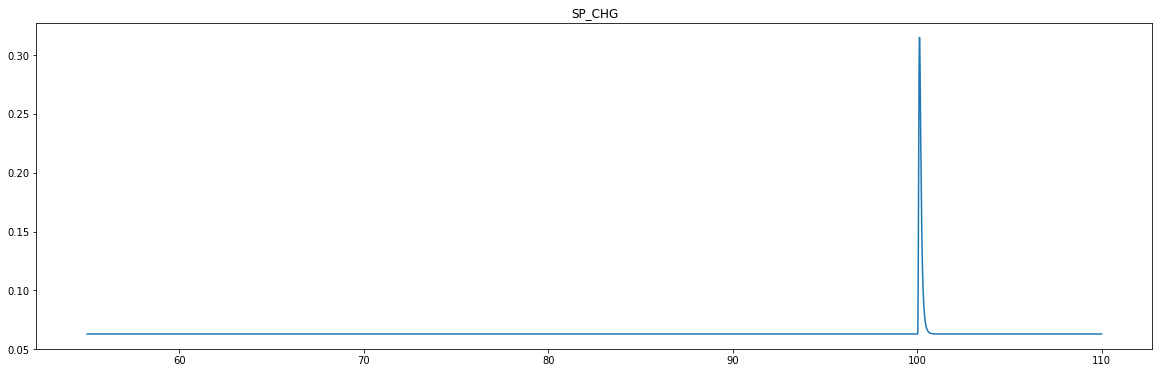

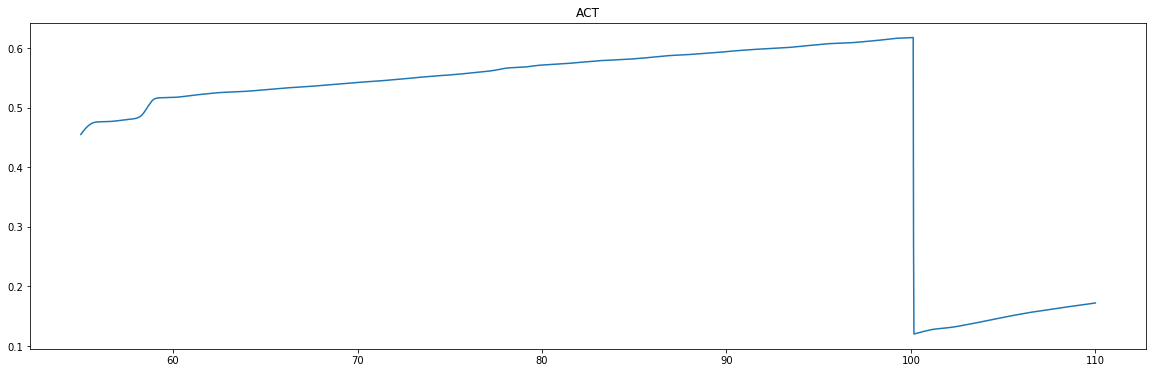

In [9]:
chg_fig = plt.figure(figsize=fs)
chg_data = np.array(data[SP_CHG])[0]
plt.plot(times, chg_data)
plt.title('SP_CHG')

act_fig = plt.figure(figsize=fs)
act_data = np.array(data[ACT])[0]
plt.plot(times, act_data)
plt.title('ACT')
plt.show()

AF_data:
[0.83785565 0.35678715 1.63821656 0.90156551 0.35872487 1.97367223
 0.30698136 0.4565851  1.8980539  0.39392905 0.45096478 1.20186291
 1.01683211 0.39647606 1.131903   0.56186449 0.41176476 2.09866304]


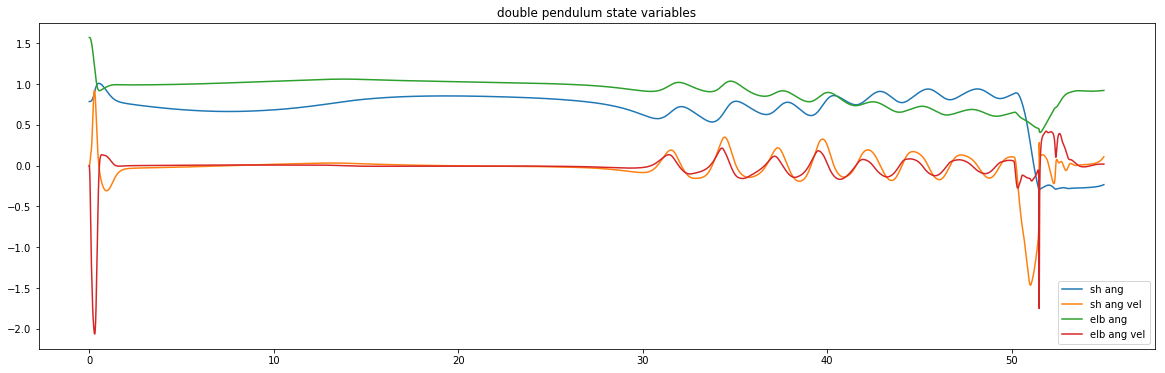

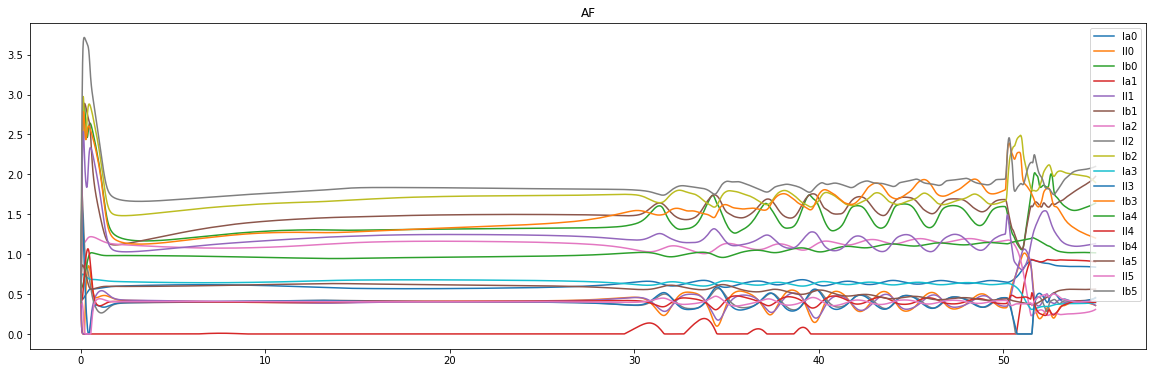

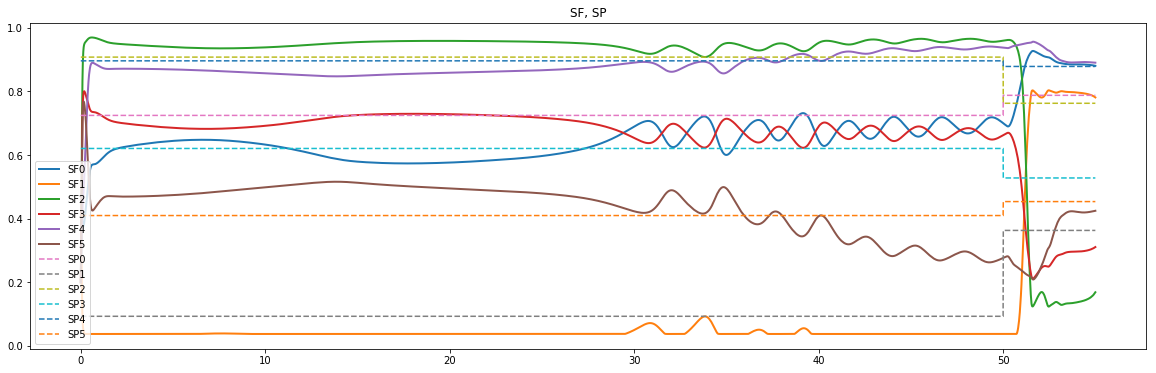

SF = 
[0.88021701 0.78084112 0.16845117 0.31053821 0.89005123 0.42452179]
SP = 
[0.78746805 0.36279296 0.7624511  0.52769624 0.87823577 0.45346245]


In [6]:
# P
P_fig = plt.figure(figsize=fs)
P_state = plant_data[P][:,0:4]
plt.plot(times, P_state)
plt.legend(['sh ang', 'sh ang vel', 'elb ang', 'elb ang vel'])
plt.title('double pendulum state variables')
#print("angle: %f, vel: %f" % (P_data[-1,0],P_data[-1,1]))

# AF
AF_fig = plt.figure(figsize=fs)
AF_data = np.array(data[AF])
plt.plot(times, AF_data.transpose())
li = [['Ia'+ str(i), 'II' + str(i), 'Ib' + str(i)] for i in range(int(len(AF)/3))]
AF_legends = []
for l in li: AF_legends += l
plt.legend(AF_legends)
plt.title('AF')
print('AF_data:')
print(AF_data[:,-1])

# SF, SP
SF_fig = plt.figure(figsize=fs)
SF_data = np.array(data[SF])
SP_data = np.array(data[SP])
plt.plot(times, SF_data.transpose(), linewidth=2)
plt.plot(times, SP_data.transpose(), '--')
SF_legends = ['SF'+str(i) for i in range(len(SF))]
SP_legends = ['SP'+str(i) for i in range(len(SP))]
plt.legend(SF_legends+SP_legends)
plt.title('SF, SP')
plt.show()
print('SF = ')
print(SF_data[:,-1])
print('SP = ')
print(SP_data[:,-1])

X=0


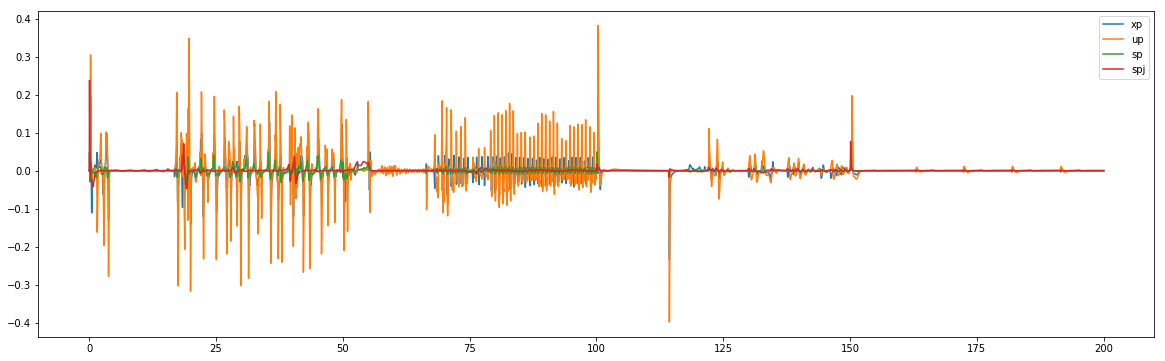

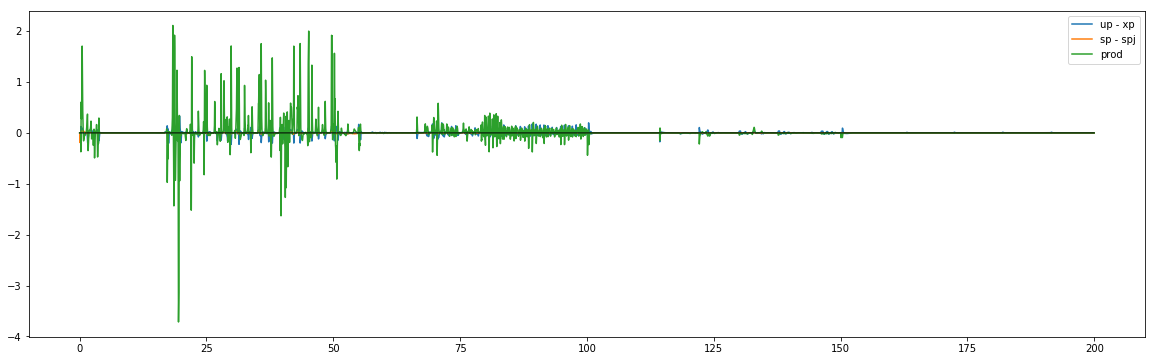

In [7]:
# plot all factors in the MX--C0 synaptic plasticity
print('X=%d' % (X))
fs = (20,6)
plastic_fig = plt.figure(figsize=fs)
xp_data = np.array(data[xp_track[0]])
up_data = np.array(data[up_track[0]])
sp_data = np.array(data[sp_track[0]])
spj_data = np.array(data[spj_track[0]])
plt.plot(times, xp_data)
plt.plot(times, up_data)
plt.plot(times, sp_data)
plt.plot(times, spj_data)
plt.legend(['xp', 'up', 'sp', 'spj'])

plastic_fig2 = plt.figure(figsize=fs)
f1 = up_data - xp_data
f2 = sp_data - spj_data
rule = 500. * f1 * f2
plt.plot(times, f1)
plt.plot(times, f2)
plt.plot(times, rule)
plt.plot(times, np.zeros(len(times)), 'k', linewidth=1)
plt.legend(['up - xp', 'sp - spj', 'prod'])
plt.show()

AL_data:
[0.11758067 0.29639495 0.07096224 0.07311072 0.08154151 0.0887876 ]


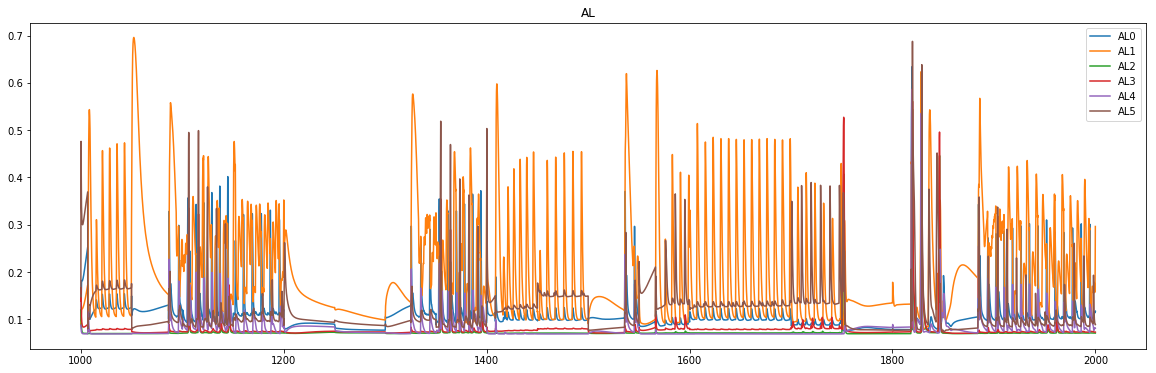

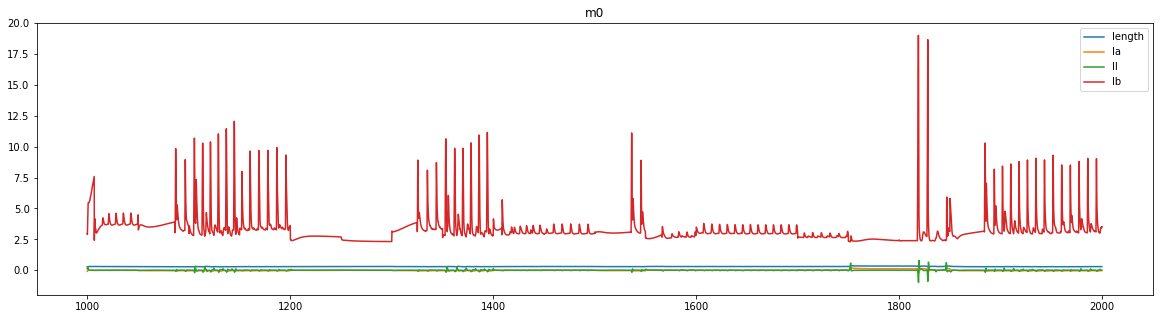

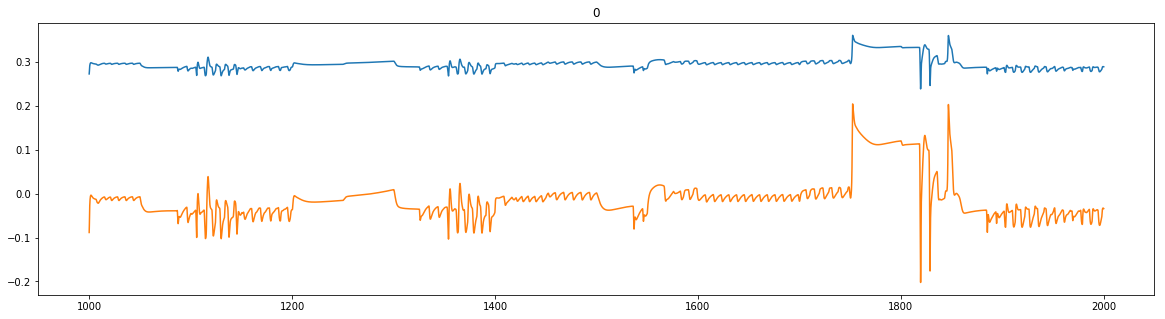

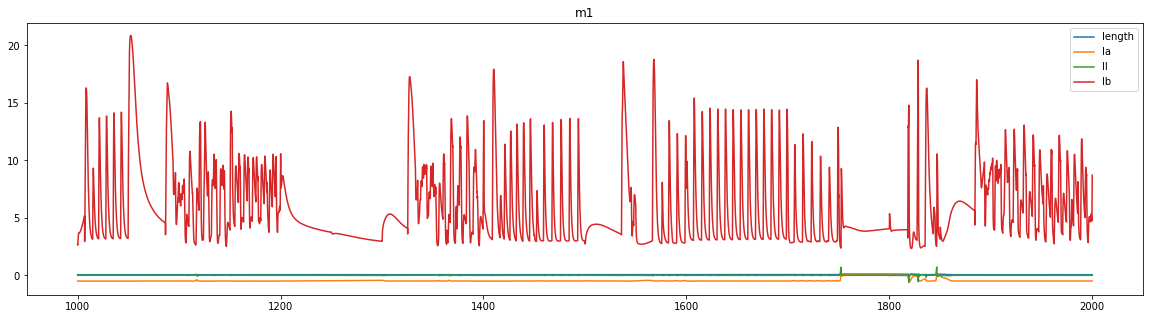

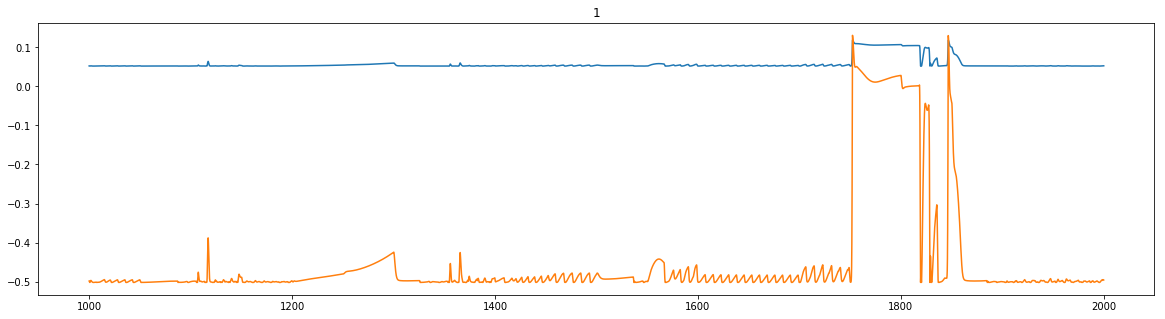

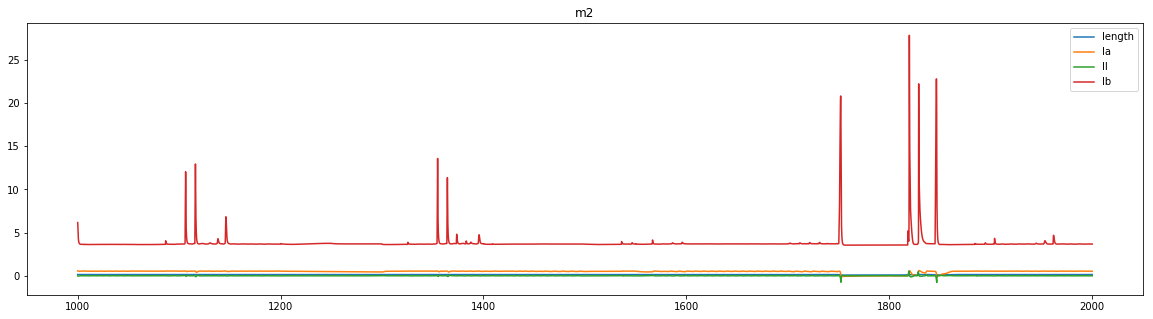

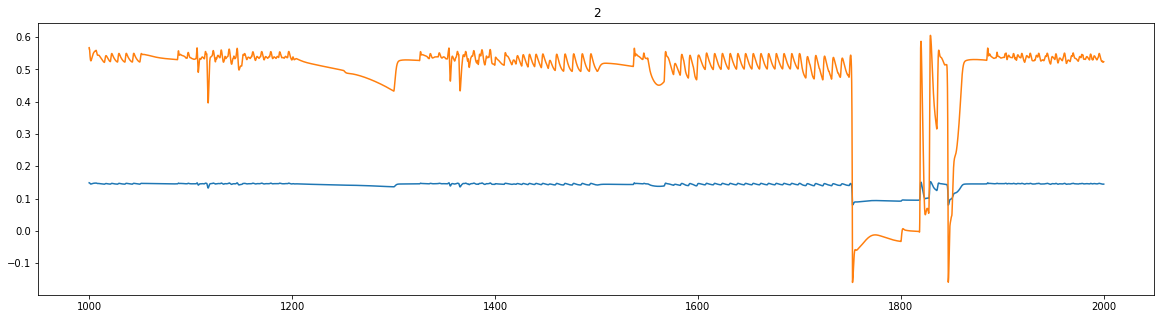

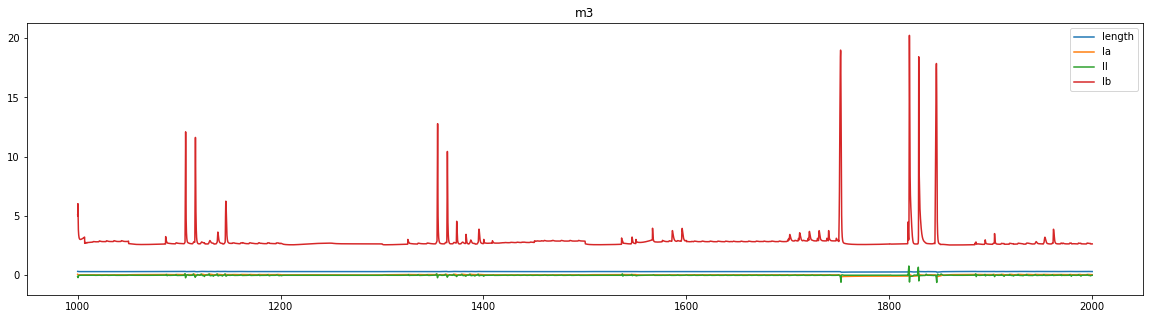

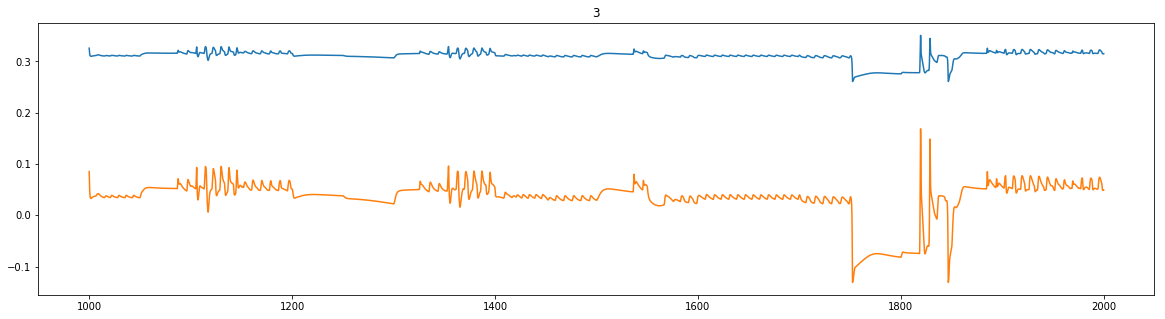

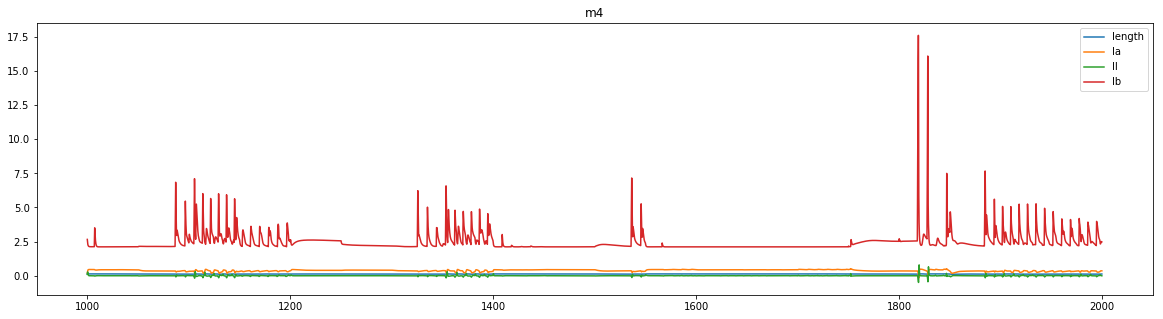

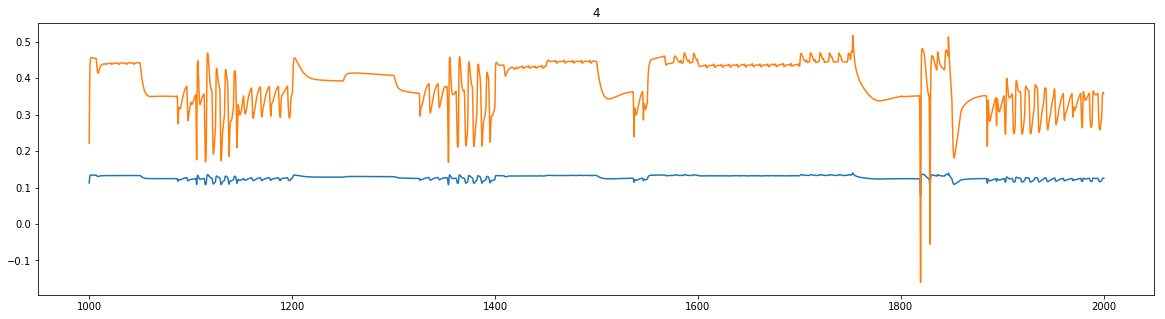

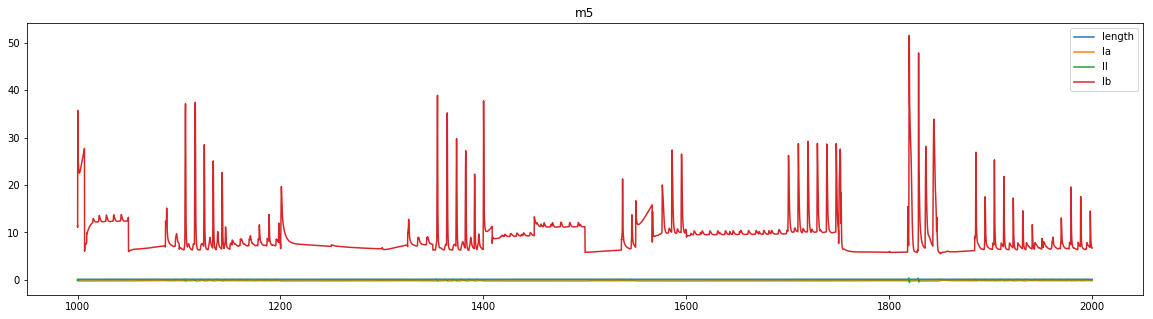

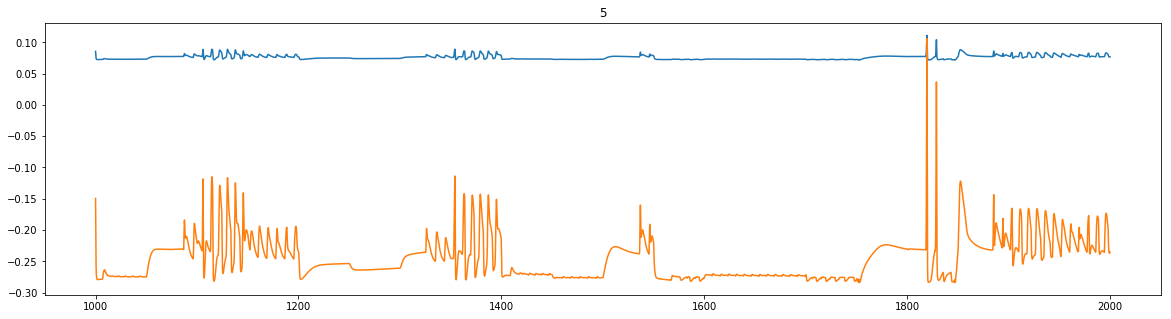

In [11]:
# Alpha units
AL_fig = plt.figure(figsize=fs)
AL_data = np.array(data[AL])
plt.plot(times, AL_data.transpose())
li = [['Ia'+ str(i), 'II' + str(i), 'Ib' + str(i)] for i in range(int(len(AF)/3))]
AL_legends = ['AL'+str(i) for i in range(len(AL))]
plt.legend(AL_legends)
plt.title('AL')
print('AL_data:')
print(AL_data[:,-1])

# plotting muscle outputs
fs = (20,5)
legs = ['length', 'Ia', 'II', 'Ib']

for i in range(6):
    next_fig = plt.figure(figsize=fs)
    affs = arm_activs[:,4+4*i:8+4*i]
    lens = arm_activs[:,4+4*i:6+4*i]
    plt.plot(times, affs)
    plt.legend(legs)
    plt.title('m' + str(i))
    plt.figure(figsize=fs)
    plt.plot(times, lens)
    plt.title(str(i))
plt.show()

In [8]:
# checking some connections
print("Connections to motor units")
for idx, syn in enumerate(net.syns[M[0]]):
    pre_id = syn.preID
    pre_type = net.units[pre_id].type
    if pre_id == P:
        pre_pop = 'P'
    elif pre_id in AF:
        pre_pop = 'AF'
    elif pre_id in SPF:
        pre_pop = 'SPF'
    else:
        pre_pop = 'erroneous'
    if pre_pop == 'P':
        plant_out = str(syn.plant_out)
    else:
        plant_out = 'None'
    print('%d) %s (%d) --> M, w=%f, port=%d, plant_out=%s'%(idx, pre_pop, pre_id, syn.w, syn.port, plant_out))
print("-------------------------\n")
    
print("Connections to afferent units")
for idx, syn in enumerate(net.syns[AF[0]]):
    pre_id = syn.preID
    pre_type = net.units[pre_id].type
    if pre_id == P:
        pre_pop = 'P'
    elif pre_id in AF:
        pre_pop = 'A'
    elif pre_id in SPF:
        pre_pop = 'SPF'
    else:
        pre_pop = 'erroneous'
    if pre_pop == 'P':
        plant_out = str(syn.plant_out)
    else:
        plant_out = 'None'
    print('%d) %s (%d) --> A, w=%f, port=%d, plant_out=%s'%(idx, pre_pop, pre_id, syn.w, syn.port, plant_out))
print("-------------------------\n")
    
print("Connections to spinal units")
for idx, syn in enumerate(net.syns[CE[2]]):
    pre_id = syn.preID
    pre_type = net.units[pre_id].type
    if pre_id == P:
        pre_pop = 'P'
    elif pre_id in AF:
        pre_pop = 'A'
    elif pre_id in SPF:
        pre_pop = 'SPF'
    elif pre_id in M:
        pre_pop = 'M'
    elif pre_id in CE:
        pre_pop = 'CE'
    elif pre_id in CI:
        pre_pop = 'CI'
    else:
        pre_pop = 'erroneous'
    if pre_pop == 'P':
        plant_out = str(syn.plant_out)
    else:
        plant_out = 'None'
    print('%d) %s (%d) --> CE, w=%f, port=%d, plant_out=%s'%(idx, pre_pop, pre_id, syn.w, syn.port, plant_out))
print("-------------------------\n")

for idx, syn in enumerate(net.syns[CI[0]]):
    pre_id = syn.preID
    pre_type = net.units[pre_id].type
    if pre_id == P:
        pre_pop = 'P'
    elif pre_id in AF:
        pre_pop = 'AF'
    elif pre_id in SPF:
        pre_pop = 'SPF'
    elif pre_id in M:
        pre_pop = 'M'
    elif pre_id in CE:
        pre_pop = 'CE'
    elif pre_id in CI:
        pre_pop = 'CI'
    else:
        pre_pop = 'erroneous'
    if pre_pop == 'P':
        plant_out = str(syn.plant_out)
    else:
        plant_out = 'None'
    print('%d) %s (%d) --> CI, w=%f, port=%d, plant_out=%s'%(idx, pre_pop, pre_id, syn.w, syn.port, plant_out))
print("-------------------------\n")


print("Connections to plant")
for idx, syn in enumerate(net.plants[P].inp_syns[0]):
    pre_id = syn.preID
    pre_type = net.units[pre_id].type
    if pre_id in AL:
        pre_pop = 'AL'
    else:
        pre_pop = 'erroneous'
    print('%d) %s (%d, %s) --> P, w=%f'%(idx, pre_pop, pre_id, pre_type, syn.w))
print("-------------------------\n")

print("Connections to SF units")
for idx, syn in enumerate(net.syns[SF[0]]):
    pre_id = syn.preID
    pre_type = net.units[pre_id].type
    if pre_id == P:
        pre_pop = 'P'
    elif pre_id in AF:
        pre_pop = 'AF'
    elif pre_id in SPF:
        pre_pop = 'SPF'
    elif pre_id in M:
        pre_pop = 'M'
    else:
        pre_pop = 'erroneous'
    if pre_pop == 'P':
        plant_out = str(syn.plant_out)
    else:
        plant_out = 'None'
    print('%d) %s (%d) --> SF, w=%f, port=%d, plant_out=%s'%(idx, pre_pop, pre_id, syn.w, syn.port, plant_out))

Connections to motor units
0) AF (24) --> M, w=-0.064464, port=0, plant_out=None
1) AF (25) --> M, w=-0.212879, port=0, plant_out=None
2) AF (26) --> M, w=0.124910, port=0, plant_out=None
3) AF (27) --> M, w=0.252974, port=0, plant_out=None
4) AF (28) --> M, w=-0.004600, port=0, plant_out=None
5) AF (29) --> M, w=0.094914, port=0, plant_out=None
6) AF (30) --> M, w=0.027905, port=0, plant_out=None
7) AF (31) --> M, w=0.287752, port=0, plant_out=None
8) AF (32) --> M, w=-0.007942, port=0, plant_out=None
9) AF (33) --> M, w=-0.068003, port=0, plant_out=None
10) AF (34) --> M, w=-0.045818, port=0, plant_out=None
11) AF (35) --> M, w=-0.287225, port=0, plant_out=None
12) AF (36) --> M, w=-0.295645, port=0, plant_out=None
13) AF (37) --> M, w=-0.261652, port=0, plant_out=None
14) AF (38) --> M, w=-0.176463, port=0, plant_out=None
15) AF (39) --> M, w=-0.093307, port=0, plant_out=None
16) AF (40) --> M, w=0.235674, port=0, plant_out=None
17) AF (41) --> M, w=-0.457874, port=0, plant_out=None

Here are some weights for the M-CE, M-CI, and A-M connections that I'd ideally would like to see develop in PART 2.
* When M and SPF have 6 units each, and SPF has SP-SF:

    MX to CEY
        0. iff X=Y, 
        0. if Y is agonist, 
        0. if partial agonist, 
        0.3 if partial antagonist, 
        1. if antagonist.
        
    MX to CIY
        1. iff X=Y, 
        0.3 if Y is agonist, 
        0.1 if partial agonist, 
        0. if partial antagonist, 
        0. if antagonist.   

    AX to MY
        (0., -0.4, 0.4) if X corresponds to Y
        (0, -0.2, 0.2) if X corresponds to an agonist of Y
        (0., 0., 0.) if X corresponds to a partial agonist of Y
        (0., 0.2, -0.2) if X corresponds to a partial antagonist of Y
        (0., 0.4, -0.4) if X corresponds to an antagonist of Y


---

In [8]:
#Animation of the arm and muscles
%matplotlib widget
from numpy import cos, sin
from matplotlib.animation import FuncAnimation

# angles of shoulder and elbow
theta_s = arm_activs[:,0]
theta_e = arm_activs[:,2]
phi = theta_s + theta_e # elbow angle wrt x axis
# data from tracking units
acts = np.array(data[1])
ipx = data[ipx_track]
ipy = data[ipy_track]
ten = arm_activs[:, np.array(range(7, 28, 4))].transpose()
# coordinates of hand and elbow
l1 = net.plants[P].l_arm
l2 = net.plants[P].l_farm
xe = cos(theta_s)*l1
ye = sin(theta_s)*l1
xh = xe + cos(phi)*l2
yh = ye + sin(phi)*l2
# creating the figure and axis
fig = plt.figure(figsize=(10,10))
plt.axis('equal')
ax = plt.gca()
lim = l1 + l2
ax.set_xlim([-lim, lim])
ax.set_ylim([-lim, lim])
ax.grid()
# creating lines and points
line, = ax.plot([], [], 'o-b', lw=2)
points, = ax.plot([], [], '+k')
target, = ax.plot([], [], 'gD')
# preparing a colormap for the tensions
ten_max = max(ten.max(), 1e-5)
ten_min = min(ten.min(), -1e-5)
for row_idx, row in enumerate(ten):
    for ent_idx, entry in enumerate(row):
        if entry > 0:
            ten[row_idx, ent_idx] = entry/ten_max
        else:
            ten[row_idx, ent_idx] = entry/abs(ten_min)
#ten = (ten / 2.) + 0.5 # we'll have only positive tensions
mus_lines = []
#cmap=plt.get_cmap('Reds')
#cmap=plt.get_cmap('coolwarm')
cmap=plt.get_cmap('bwr')
for i in range(6):
    mus_lines.append(ax.plot([], [], color=cmap(0.5))[0])
# stuff used to plot the target
strt_idx = int(np.round(times[0]/t_pres)) # initial index in m_idxs

def init():
    line.set_data([], [])
    points.set_data([], [])
    for i in range(6):
        mus_lines = []
        mus_lines.append(ax.plot([], [], color=cmap(0.5))[0])
    return line, points, mus_lines

def update(frame):
    coord_x = [0, xe[frame], xh[frame]]
    coord_y = [0, ye[frame], yh[frame]]
    ip_x = ipx[:,frame]
    ip_y = ipy[:,frame]
    tens = ten[:, frame]
    line.set_data(coord_x, coord_y)
    points.set_data(ip_x, ip_y)
    for i, ml in enumerate(mus_lines):
        idx = 2*i
        ml.set_data(ip_x[idx:idx+2], ip_y[idx:idx+2])
        ml.set_color(cmap(tens[i]))
    
    cur_time = frame*net.min_delay
    fig.suptitle('time: ' + '{:f}'.format(cur_time))
    # plotting target
    cur_idx = int(cur_time/t_pres) + strt_idx
    x_coord, y_coord = hand_coords[m_idxs[cur_idx]]
    target.set_data([x_coord], [y_coord])
    
    return line, points, muls_lines #muscle1

ani = FuncAnimation(fig, update, frames=np.arange(0, len(theta_s), 5), init_func=init, blit=True, interval=10)

plt.show()

FigureCanvasNbAgg()

In [11]:
ipx.shape

(12, 4000)